In [1]:
# 双光融合主程序

import sys
import threading
import msvcrt
import cv2
from cv2 import INTER_NEAREST
import numpy as np
import time
import math
import seaborn as sns
import matplotlib.pyplot as plt
import matplotlib
 
from ctypes import *

sys.path.append("../MvImport")
from MvCameraControl_class import *
 
g_bExit = False
# 图像翻转标志
ReverseX_YES = 1
ReverseX_NO = 0 

#-------------------------参数设置-----------------------------
global deviceList
global tlayerType
global bench #标定温度 和灰度
global benchtemperature
bench = 3500
benchtemperature = 2045.125
global Lamda1, Lambda2 # 双光使用的波长
Lambda1 = 800 # (nm)
Lambda2 = 700 # (nm)
global threshold # 计算温度时阈值灰度，小于此值进行处理
threshold = 0
#------------------------------------------------------


# 侦察设备并并开启设备 
def DetectDevice():
    #input:  NULL
    #output: deviceList  
    # global Lambda1
    # global Lambda2
    # Lambda1 = 800 # (nm)
    # Lambda2 = 700 # (nm)
    deviceList = MV_CC_DEVICE_INFO_LIST()
    tlayerType = MV_GIGE_DEVICE | MV_USB_DEVICE

    # ch:枚举设备 | en:Enum device
    ret = MvCamera.MV_CC_EnumDevices(tlayerType, deviceList)
    if ret != 0:
        print("enum devices fail! ret[0x%x]" % ret)
        sys.exit()

    if deviceList.nDeviceNum == 0:
        print("find no device!")
        sys.exit()

    print("Find %d devices!" % deviceList.nDeviceNum)

    for i in range(0, deviceList.nDeviceNum):
        mvcc_dev_info = cast(deviceList.pDeviceInfo[i], POINTER(MV_CC_DEVICE_INFO)).contents
        if mvcc_dev_info.nTLayerType == MV_GIGE_DEVICE:
            print("\ngige device: [%d]" % i)
            strModeName = ""
            for per in mvcc_dev_info.SpecialInfo.stGigEInfo.chModelName:
                strModeName = strModeName + chr(per)
            print("device model name: %s" % strModeName)

            nip1 = ((mvcc_dev_info.SpecialInfo.stGigEInfo.nCurrentIp & 0xff000000) >> 24)
            nip2 = ((mvcc_dev_info.SpecialInfo.stGigEInfo.nCurrentIp & 0x00ff0000) >> 16)
            nip3 = ((mvcc_dev_info.SpecialInfo.stGigEInfo.nCurrentIp & 0x0000ff00) >> 8)
            nip4 = (mvcc_dev_info.SpecialInfo.stGigEInfo.nCurrentIp & 0x000000ff)
            print("current ip: %d.%d.%d.%d\n" % (nip1, nip2, nip3, nip4))
            
            # # 判断仪器ip并决定,以防连接后图像出现混肴
            # if nip4==78 & i==0:
            #     Lambda1 = 700
            #     Lambda2 = 800
            #     print("set Lamda1 700 and Lamda2 800")
            #     continue
            

        elif mvcc_dev_info.nTLayerType == MV_USB_DEVICE:
            print("\nu3v device: [%d]" % i)
            strModeName = ""
            for per in mvcc_dev_info.SpecialInfo.stUsb3VInfo.chModelName:
                if per == 0:
                    break
                strModeName = strModeName + chr(per)
            print("device model name: %s" % strModeName)

            strSerialNumber = ""
            for per in mvcc_dev_info.SpecialInfo.stUsb3VInfo.chSerialNumber:
                if per == 0:
                    break
                strSerialNumber = strSerialNumber + chr(per)
            print("user serial number: %s" % strSerialNumber)
    return deviceList

# 连接设备并设置参数
def ConnectDevice(nConnectionNum, ReverseFlag):         
    #input:  连接设备号码, ReverseFlag 双光融合时一台相机图像需要翻转的标志位
    #output: MvCamera实例Cam 
    # 设置相机的各项参数
    
    # nConnectionNum = input("please input the number of the device to connect:")
    if int(nConnectionNum) >= deviceList.nDeviceNum:
        print("intput error!")
        sys.exit()

    # ch:创建相机实例 | en:Creat Camera Object
    cam = MvCamera()

    # ch:选择设备并创建句柄 | en:Select device and create handle
    stDeviceList = cast(deviceList.pDeviceInfo[int(nConnectionNum)], POINTER(MV_CC_DEVICE_INFO)).contents

    ret = cam.MV_CC_CreateHandle(stDeviceList)
    if ret != 0:
        print("create handle fail! ret[0x%x]" % ret)
        sys.exit()

    # ch:打开设备 | en:Open device
    ret = cam.MV_CC_OpenDevice(MV_ACCESS_Exclusive, 0)
    if ret != 0:
        print("open device fail! ret[0x%x]" % ret)
        sys.exit()

    # ch:探测网络最佳包大小(只对GigE相机有效) | en:Detection network optimal package size(It only works for the GigE camera)
    if stDeviceList.nTLayerType == MV_GIGE_DEVICE:
        nPacketSize = cam.MV_CC_GetOptimalPacketSize()
        nPacketRate = 1410 # 实现带宽500MB
        if int(nPacketSize) > 0:
            # 设置两项参数实现带宽500MB
            ret = cam.MV_CC_SetIntValue("GevSCPSPacketSize", nPacketSize)
            ret = cam.MV_CC_SetIntValue("GevSCPD", nPacketRate)
            if ret != 0:
                print("Warning: Set Packet Size fail! ret[0x%x]" % ret)
        else:
            print("Warning: Get Packet Size fail! ret[0x%x]" % nPacketSize)

    stBool = c_bool(False)
    ret = cam.MV_CC_GetBoolValue("AcquisitionFrameRateEnable", stBool)
    if ret != 0:
        print("get AcquisitionFrameRateEnable fail! ret[0x%x]" % ret)
        sys.exit()

    # ch:设置曝光时间
    # - 增益 Node Name: Gain Type: Float
    nExposureTime = 10000
    ret = cam.MV_CC_SetFloatValue("ExposureTime", nExposureTime)
    nGain = 0
    ret = cam.MV_CC_SetFloatValue("Gain", nGain)

    # Y轴图像翻转   Node Name: ReverseX         Type: Boolean
    # 自动曝光      Node Name: ExposureAuto     Type: Enumeration
    # 自动增益      Node Name: GainAuto         Type: Enumeration
    # 软触发        Enum Entry Name: Software   Enum Entry Value: 7
    reverseBool = c_bool(ReverseFlag)
    ret = cam.MV_CC_SetBoolValue("ReverseX", reverseBool)
    nTriggerValue = 7 # 软触发
    cam.MV_CC_SetEnumValue("software", nTriggerValue)
    cam.MV_CC_SetEnumValueByString("GainAuto", "Off")
    cam.MV_CC_SetEnumValueByString("ExposureAuto", "Off")

    # 设置width和height 以及layoutx y来调节图像大小，进而实现图像的帧率
    # width 1832 height 1500 layoutx 700 layouty 400
    nWidth  = 1832
    nHeight = 1500
    offsetX = 700
    offsetY = 400
    cam.MV_CC_SetIntValue("Width", nWidth)
    cam.MV_CC_SetIntValue("Height", nHeight)
    cam.MV_CC_SetIntValue("OffsetX", offsetX)
    cam.MV_CC_SetIntValue("OffsetY", offsetY)

    # ch:设置触发模式为off | en:Set trigger mode as off
    ret = cam.MV_CC_SetEnumValue("TriggerMode", MV_TRIGGER_MODE_OFF)
    if ret != 0:
        print("set trigger mode fail! ret[0x%x]" % ret)
        sys.exit()

    # ch:设置图像像素 | en:Set the pixelFormat of the image
    ret = cam.MV_CC_SetEnumValue("PixelFormat", PixelType_Gvsp_Mono12)
    if ret != 0: 
        print ("set PixelFormat fail! nRet [0x%x]" % ret)
        sys.exit()

    return cam

# 获取设备状态信息
def GetCameraParameters(cam):
    # # 获取带宽、曝光、像素格式、帧率、最大值、最小值、触发模式、增益、单张图片大小等等
    # nWidth = c_uint(0)
    # nHeight = c_uint(0)
    # cam.MV_CC_GetIntValue("Width", nWidth)
    # cam.MV_CC_GetIntValue("Height", nHeight)

    # # ch:获取图像像素 | en:Get the pixelFormat of the image
    # stEnumValue = MVCC_ENUMVALUE()
    # memset(byref(stEnumValue), 0 ,sizeof(MVCC_ENUMVALUE))
    # ret = cam.MV_CC_GetEnumValue("PixelFormat", stEnumValue)
    # if ret != 0: 
    #     print ("get PixelFormat fail! nRet [0x%x]" % ret)
    #     sys.exit()
    # if stEnumValue.nCurValue == PixelType_Gvsp_Mono12:
    #     print("set PixelFormat succeed!")

    # # ch:打开属性配置GUI | en:Open Parameter Configuration GUI
    # nRet = cam.MV_CC_OpenParamsGUI();
    # if ret != 0:
    #     printf("Open Parameters Configuration GUI fail! nRet [0x%x]\n", nRet);
    #     sys.exit()
    # print("Press a key to close camera.\n");
    # msvcrt.getch()

    return 0 

# 关闭设备
def CloseDevice(cam):
    ##############################

    # try:
    #     hThreadHandle = threading.Thread(target=work_thread, args=(cam, None, None))
    #     hThreadHandle.start()
    # except:
    #     print ("error: unable to start thread")
    # g_bExit = True
    # hThreadHandle.join()

    # ch:停止取流 | en:Stop grab image
    ret = cam.MV_CC_StopGrabbing()
    if ret != 0:
        print("stop grabbing fail! ret[0x%x]" % ret)
        sys.exit()

    # ch:关闭设备 | Close device
    ret = cam.MV_CC_CloseDevice()
    if ret != 0:
        print("close deivce fail! ret[0x%x]" % ret)
        sys.exit()

    # ch:销毁句柄 | Destroy handle
    ret = cam.MV_CC_DestroyHandle()
    if ret != 0:
        print("destroy handle fail! ret[0x%x]" % ret)
        sys.exit()
     
    keyValue = cv2.waitKey()
    cv2.destroyAllWindows()
    
# ***************************************************************************************************************    
# 各项功能的函数
# ***************************************************************************************************************   

# 计算温度值
def GetTemperature(greylevel):
    A = 3357.86668129799
    B = -0.346495384076732
    C = 14665.1652494004
    D = 668.451983297123
    T = (A - D)/(1 + np.power((greylevel/C), B))+D
    return T

# 过滤极小值，避免算法处理中的偏差
def ThresholdProcess(pic):
    # input:    8位or16位numpy array数据
    # output:   处理过的 8位or16位numpy array数据
    # 值过小对于图像影响很大，需要算法上处理
    pic = pic.astype(np.float16)
    # pic[np.where(pic <= threshold)] = np.inf
    pic = pic - 11
    pic[np.where(pic <= 0)] = 0
    return pic

# 高斯滤波
def filterGuassian(pic):
    return 0

# 全图温度计算，归一化，彩色显示
def GetTemperaturePic(greypic):
    greypic =  ThresholdProcess(greypic)
    A = 3357.86668129799
    B = -0.346495384076732
    C = 14665.1652494004
    D = 668.451983297123
    T16 = (A - D)/(1 + np.power((greypic/C), B))+D
    T_max = 1800 #额定温度上限
    T16[np.where(T16 <= 800)] = 0
    T = T16/T_max*255
    T = T.astype(np.uint8)
    # 返回8位色彩图
    return T16, T, (np.max(T16))

# 加入图例和温度曲线
def PseudoColor(temperaturepic):  
    return cv2.applyColorMap(cv2.convertScaleAbs(temperaturepic, alpha=1), cv2.COLORMAP_HOT)

# ch:将缓存区mono12图像数据转换成16位图像，单字节用uint16表示
def Mono12toImg16(Mono12, IHeight, IWidth):
    Mat = np.reshape(Mono12, (-1, 2)).astype(np.int16)
    cell = np.array([[1],[256]])
    Img16 = np.matmul(Mat, cell)
    Img16 = np.reshape(Img16, (IHeight, IWidth))
    # print(np.shape(Img16))
    # print(Img16)
    return Img16

# ch:将16位图像映射到8位图像进行显示
def Img16toImg8(Img16):
    return (Img16/16).astype(np.uint8)

# 获取图像并预处理
def GetImage(cam):
    sec = 0
    data_buf = None
    stOutFrame = MV_FRAME_OUT()
    memset(byref(stOutFrame), 0, sizeof(stOutFrame))
    ret = cam.MV_CC_GetImageBuffer(stOutFrame, 1000)
    if None != stOutFrame.pBufAddr and 0 == ret:
        if data_buf == None:
            data_buf = (c_ubyte * stOutFrame.stFrameInfo.nFrameLen)()
        # print("get one frame: Width[%d], Height[%d], nFrameNum[%d]" % (
        #     stOutFrame.stFrameInfo.nWidth, stOutFrame.stFrameInfo.nHeight, stOutFrame.stFrameInfo.nFrameNum))
        cdll.msvcrt.memcpy(byref(data_buf), stOutFrame.pBufAddr, stOutFrame.stFrameInfo.nFrameLen)
        temp = np.asarray(data_buf)
        # 对缓存区的mono12图像数据进行处理
        nWidth = c_uint(0)
        nHeight = c_uint(0)
        cam.MV_CC_GetIntValue("Width", nWidth)
        cam.MV_CC_GetIntValue("Height", nHeight)

        OriginalData = Mono12toImg16(temp.astype(np.uint8), nHeight.value, nWidth.value)
        ImshowData = Img16toImg8(OriginalData)

        nRet = cam.MV_CC_FreeImageBuffer(stOutFrame)
        return OriginalData, ImshowData
    else:
        print ("get one frame fail, ret[0x%x]" % ret)

if __name__ == "__main__":

    deviceList = DetectDevice()
    print("OUT find %d device(s)" % deviceList.nDeviceNum)
    cam1 = ConnectDevice(0, ReverseX_NO)
    cam2 = ConnectDevice(1, ReverseX_YES) 
    # ch:开始取流 | en:Start grab image
    ret1 = cam1.MV_CC_StartGrabbing()
    ret2 = cam2.MV_CC_StartGrabbing()
    if ret1 | ret2 != 0:
        print("start grabbing fail! ret[0x%x]" % ret1)
        print("start grabbing fail! ret[0x%x]" % ret2)
        sys.exit()

    ##实时显示
    keyValue = 0
    fra1 = []
    fra2 = []
    FirstGetSiftPara = True
    while keyValue != ord('q'):
        
        # 从cam句柄获取12位原始数据和8位换算数据
        # 如果双光还要翻转图像
        originalsrc1, src1 = GetImage(cam1) # originalsrc为12位，src为8位
        originalsrc2, src2 = GetImage(cam2)
        # 图像融合  
        # 相机1单色光测温
        src_T16_1, src_T_1, src_maxT1 = GetTemperaturePic(originalsrc1) # 这个函数是针对8为定制的需要改善
        src_T16_2, src_T_2, src_maxT2 = GetTemperaturePic(originalsrc2) # 这个函数是针对8为定制的需要改善

        temperwhere = np.where(src_T16_1 == np.max(src_T16_1))
        temperx = temperwhere[0][0]
        tempery = temperwhere[1][0]
        temperature = src_T16_1[(temperx-30):(temperx+30),(tempery-30):(tempery+30)]

        plt.figure("Image")  # 图像窗口名称
        sns.heatmap(temperature, linewidths = 0, vmax=2000, vmin=1000, cmap='jet')
        plt.title('image')  # 图像题目
        plt.axis('on')
        plt.xticks(rotation=90)
        # 必须有这个，要不然无法显示
        %matplotlib
        plt.show()

       
        
        # src_TC1 = PseudoColor(src_T1) # 伪彩色图像
        # fra1.append(np.max(originalsrc1))
        # mean1 = sum(fra1)/len(fra1)
        # if(len(fra1)>50):
        #     fra1.remove(fra1[0])

        # temperwhere = np.where(src_T1 == np.max(src_T1))
        # temperx = temperwhere[0][0]
        # tempery = temperwhere[1][0]
        # temperature = PseudoColor(src_T1)
        # if temperx == 0: # 故障排除
        #     if tempery == 0:
        #         temperx = 50
        #         tempery = 50
        # cv2.imshow("5", cv2.resize(temperature[(temperx-30):(temperx+30),(tempery-30):(tempery+30),:],dsize=None,fx=10, fy=10, interpolation=INTER_NEAREST))
        
        # cv2.putText(src1, "maxgrayLevel="+str(np.max(originalsrc1)), (0, 60), cv2.FONT_HERSHEY_SIMPLEX, 2, (255, 255, 255), 2)
        # cv2.putText(src1, "meangrayLevel="+str(int(mean1)), (0, 120), cv2.FONT_HERSHEY_SIMPLEX, 2, (255, 255, 255), 2)
        # cv2.putText(src1, "temperature="+str(int(GetTemperature(mean1))), (0, 180), cv2.FONT_HERSHEY_SIMPLEX, 2, (255, 255, 255), 2)
        # cv2.imshow("1", cv2.resize(src1, (900, 600)))
        # cv2.putText(src_TC1, "maxgrayLevel="+str(np.max(originalsrc1)), (0, 60), cv2.FONT_HERSHEY_SIMPLEX, 2, (128,128,128), 2)
        # cv2.putText(src_TC1, "temperature="+str(src_maxT1), (0, 120), cv2.FONT_HERSHEY_SIMPLEX, 2, (128,128,128), 2)
        # cv2.imshow("2", cv2.resize(src_TC1,(900,600)))
        
        # # 相机2单色光测温
        # src_T2, src_maxT2 = GetTemperaturePic(originalsrc2) # 这个函数是针对8为定制的需要改善
        # src_TC2 = PseudoColor(src_T2) # 伪彩色图像
        # fra2.append(np.max(originalsrc2))
        # mean2 = sum(fra2)/len(fra2)
        # if(len(fra2)>50):
        #     fra2.remove(fra2[0])

        # temperwhere = np.where(src_T2 == np.max(src_T2))
        # temperx = temperwhere[0][0]
        # tempery = temperwhere[1][0]
        # temperature = PseudoColor(src_T2)
        # if temperx == 0: # 故障排除
        #     if tempery == 0:
        #         temperx = 50
        #         tempery = 50
        # cv2.imshow("6", cv2.resize(temperature[(temperx-30):(temperx+30),(tempery-30):(tempery+30),:],dsize=None,fx=10, fy=10, interpolation=INTER_NEAREST))
        

        # cv2.putText(src2, "maxgrayLevel="+str(np.max(originalsrc2)), (0, 60), cv2.FONT_HERSHEY_SIMPLEX, 2, (255, 255, 255), 2)
        # cv2.putText(src2, "meangrayLevel="+str(int(mean2)), (0, 120), cv2.FONT_HERSHEY_SIMPLEX, 2, (255, 255, 255), 2)
        # cv2.putText(src2, "temperature="+str(int(GetTemperature(mean2))), (0, 180), cv2.FONT_HERSHEY_SIMPLEX, 2, (255, 255, 255), 2)
        # cv2.imshow("3", cv2.resize(src2, (900, 600)))
        # cv2.putText(src_TC2, "maxgrayLevel="+str(np.max(originalsrc2)), (0, 60), cv2.FONT_HERSHEY_SIMPLEX, 2, (128,128,128), 2)
        # cv2.putText(src_TC2, "temperature="+str(src_maxT2), (0, 120), cv2.FONT_HERSHEY_SIMPLEX, 2, (128,128,128), 2)
        # cv2.imshow("4", cv2.resize(src_TC2,(900,600)))
        
        # # cv2.waitKey(10)  # time.sleep 延时没有用
        keyValue = cv2.waitKey(1)
    cv2.destroyAllWindows()
    CloseDevice(cam1)
    CloseDevice(cam2)

Find 2 devices!

gige device: [0]
device model name: MV-CA060-11GM                   
current ip: 192.168.16.88


gige device: [1]
device model name: MV-CA060-11GM                   
current ip: 192.168.16.78

OUT find 2 device(s)


d:\Users\lenovo\Anaconda3\envs\school\lib\site-packages\ipykernel_launcher.py:289: RuntimeWarning: divide by zero encountered in power


Using matplotlib backend: Qt5Agg
Using matplotlib backend: Qt5Agg
Using matplotlib backend: Qt5Agg
Using matplotlib backend: Qt5Agg
Using matplotlib backend: Qt5Agg
Using matplotlib backend: Qt5Agg
Using matplotlib backend: Qt5Agg
Using matplotlib backend: Qt5Agg


In [8]:
import numpy as np
import math
A = 3357.86668129799
B = -0.346495384076732
C = 14665.1652494004
D = 668.451983297123
y = (A - D)/(1 + np.power((X/C), B))+D


1637.6439810375273


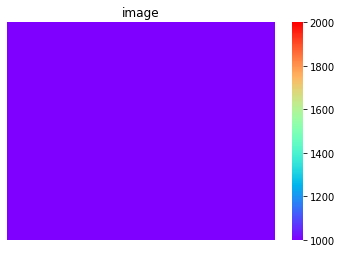

In [10]:
import cv2
import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline
img = cv2.imread('temper.jpg', 0)
plt.figure("Image")  # 图像窗口名称
sns.heatmap(img, linewidths = 0, vmax=2000, vmin=1000, cmap='rainbow')
# plt.imshow(img)
plt.title('image')  # 图像题目
plt.axis('off')
# 必须有这个，要不然无法显示
plt.show()

<class 'numpy.ndarray'>


Text(33.0, 0.5, 'kind')

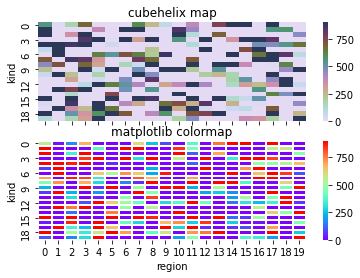

In [14]:
#cmap(颜色)
 
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
%matplotlib inline
N = 20
R = np.random.randn(N, N)*900

print(type(R))
f, (ax1,ax2) = plt.subplots(figsize = (6,4),nrows=2)
 
# cmap用cubehelix map颜色
cmap = sns.cubehelix_palette(start = 1.5, rot = 3, gamma=0.8, as_cmap = True)

sns.heatmap(R, ax = ax1, vmax=900, vmin=0, cmap=cmap)
ax1.set_title('cubehelix map')
ax1.set_xlabel('')
ax1.set_xticklabels([]) #设置x轴图例为空值
ax1.set_ylabel('kind')
 
# cmap用matplotlib colormap
sns.heatmap(R, linewidths = 0.05, ax = ax2, vmax=900, vmin=0, cmap='rainbow') 
# rainbow为 matplotlib 的colormap名称
ax2.set_title('matplotlib colormap')
ax2.set_xlabel('region')
ax2.set_ylabel('kind')